### Management and Analyisis of Physics Datasets mod. B
# Distributed Algorithms
### Group 4 (🤮) - Bacilieri, Barbiero, Bordin, Pitteri

## 0 - Abstract
A number of common algorithms used in Data Science and Machine Learning are not by default designed to take advantage of the parallelization offered by distributed systems. In this project we'll implement several K-means algorithm specifically design to take advantage of distributed systems using the PySpark API of Spark and the Cloud Veneto computing resources.

Our cluster was composed by one master node and two worker nodes providing:
```
bordin@mapd-b-2023-gr04-1:~$ lscpu | grep -E '^Thread|^Core|^Socket|^CPU\('
CPU(s):                          4
Thread(s) per core:              1
Core(s) per socket:              1
Socket(s):                       4
```
 - 4 physical cores, one thread each  
```
bordin@mapd-b-2023-gr04-1:~$ free -h --si
               total        used        free      shared  buff/cache   available
Mem:            7.9G        191M        6.7G        3.0M        1.0G        7.5G
Swap:             0B          0B          0B
```
 - 8 GB of RAM
each

## 1 - Spark Session

In [1]:
from sklearn.datasets import fetch_kddcup99

from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, udf, array, min as smin, lit, count, isnan, when, sum as ssum
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

import time
import numpy as np
import numpy.random as npr
from numpy.random import choice
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

npr.seed(5364)
spark_seed = 53108350

spark_mode = 0 for docker usage

spark_mode = 1 for Cloud Veneto usage

In [2]:
spark_mode = 1

In [3]:
if spark_mode == 0 :
    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("k-meaner") \
        .config("spark.executor.memory", "1024m") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

    
if spark_mode == 1 :
    spark = SparkSession.builder \
        .master("spark://localhost:7077")\
        .appName("k-meaner")\
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.6') \
        .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.6') \
        .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.12.99') \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .config("com.amazonaws.sdk.disableCertChecking","true") \
        .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

#clear old data if rerunning
spark.catalog.clearCache() 
for (id, rdd) in sc._jsc.getPersistentRDDs().items():
    rdd.unpersist()

23/07/16 07:41:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


## 2 - Dataset
The dataset we decided to benchmark our algorithms on is the `KDDCup99` dataset.
While we're not interested in the specific topics covered by the dataset it is still important to describe its key features

In [4]:
kdd = spark.createDataFrame(fetch_kddcup99(as_frame=True)["frame"])

kdd.printSchema()

root
 |-- duration: long (nullable = true)
 |-- protocol_type: binary (nullable = true)
 |-- service: binary (nullable = true)
 |-- flag: binary (nullable = true)
 |-- src_bytes: long (nullable = true)
 |-- dst_bytes: long (nullable = true)
 |-- land: long (nullable = true)
 |-- wrong_fragment: long (nullable = true)
 |-- urgent: long (nullable = true)
 |-- hot: long (nullable = true)
 |-- num_failed_logins: long (nullable = true)
 |-- logged_in: long (nullable = true)
 |-- num_compromised: long (nullable = true)
 |-- root_shell: long (nullable = true)
 |-- su_attempted: long (nullable = true)
 |-- num_root: long (nullable = true)
 |-- num_file_creations: long (nullable = true)
 |-- num_shells: long (nullable = true)
 |-- num_access_files: long (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: long (nullable = true)
 |-- count: long (nullable = true)
 |-- srv_count: long (nullable = true)
 |-- serror_rate: d

As we can see `kdd` is dataframe where the first elements are the features of the data points, while the last element is filled with the corresponding labels – i.e., the attack types.

### Pre Processing

- Remove the first three “categorical” columns, and keep only the numerical ones. 
- Rescale everything in [0-1] range
- In doing so, ignore the two columns that happen to be all zeros.

In [5]:
kdd = kdd.drop("protocol_type")
kdd = kdd.drop("service") 
kdd = kdd.drop("flag")

kdd.createOrReplaceTempView("kdd_table")

for c in kdd.columns:
    try:
        limits = spark.sql("SELECT min(" + c + "), max(" + c + ") FROM kdd_table").collect()
        mn, mx = limits[0][0], limits[0][1]
        
        if mn==mx: #ignore columns with no variations
            continue
        
        
        kdd = kdd.withColumn(c, (col(c)-mn)/(mx-mn) )
        
        #print(limits[0][0], limits[0][1])
    except Exception as e:
        print(e)

kdd = kdd.persist()

unsupported operand type(s) for -: 'bytearray' and 'bytearray'


In [6]:
kdd.printSchema()

root
 |-- duration: double (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: double (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror

### Attack types distribution

In [7]:
res = spark.sql("SELECT labels, count(1) FROM kdd_table GROUP BY labels").collect()

attacks = np.array([bytes(r[0]) for r in res])
counts = np.array([r[1] for r in res])
attack_sort = np.argsort(counts)
attacks = attacks[attack_sort]
counts = counts[attack_sort]

ypos = np.arange(len(attacks))

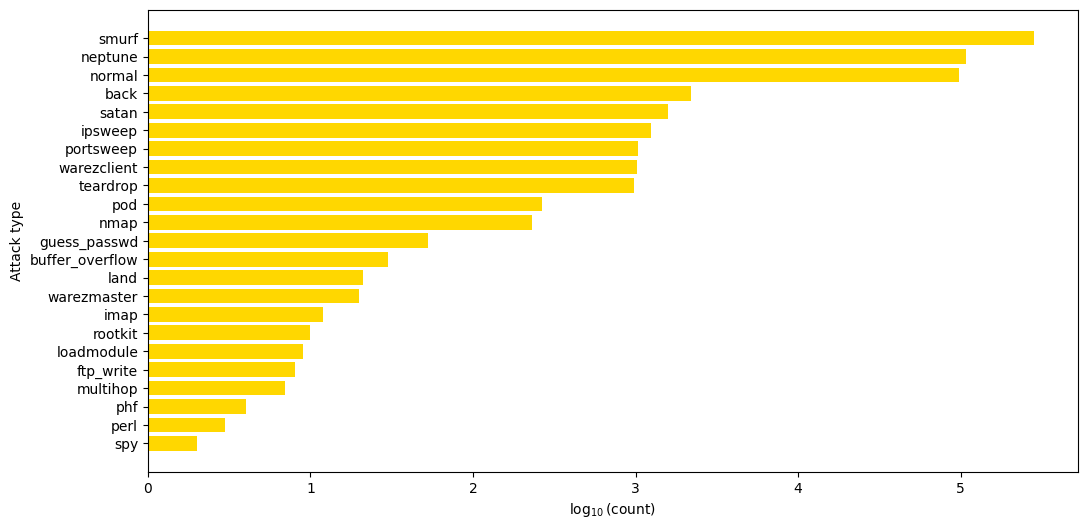

In [8]:
plt.figure(figsize=(12, 6))
plt.barh(ypos, np.log10(counts), facecolor="gold")
plt.yticks(ypos, labels=[a.decode("utf-8")[0:-1] for a in attacks])
plt.xlabel(r"$\log_{10}(\mathrm{count})$")
plt.ylabel("Attack type")
plt.show()

Attack types vary significantly in frequency so we will have to keep this in mind during later clustering

## 3 - Lloyd's Algorithm
The K means algorithm is widely used in Machine Learing clustering applications due to its simple implementation which roughly follows these steps.

- Start from a set of points as centers for the clusters
- Classify data points based on closest cluster center
- Set new cluster center as the mean of clustered points and repeat until convergence or max iterations

This algorithms is known as Lloyd's algorithm

### Prep work

In [9]:
def dist(x,y):
    try:
        #return (((np.array(x)-y)**2).sum())**0.5
        return np.linalg.norm(np.array(x)-np.array(y))
    except Exception as e:
        #print(e)
        return ncols

def argcomp(comp,func, arr, *params):
    res = [func(arr[i], *params) for i in range(len(arr))]
    #print(res)
    return res.index(comp(res))

index_udf = udf(lambda row:attacks.tolist().index(row))

Some of the columns will contain meta information about the data rows. As such, we must ignore them when calculating the distances from the centroids.

In [10]:
ignored_cols = ["labels", "centr", "cost", "p", "w"]

kdd = kdd.withColumn("labels", index_udf(col("labels")).cast("int"))
kdd = kdd.withColumn("centr", lit(-1))
kdd = kdd.withColumn("cost", lit(0.))
kdd = kdd.withColumn("p", lit(0.))

ncols = len([c for c in kdd.columns if c not in ignored_cols])

kdd.printSchema()

root
 |-- duration: double (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: long (nullable = true)
 |-- is_host_login: long (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: double (nullable = true)
 |-- serror_rate: double (nullable = true)
 |-- srv_serror_rate: double (nullable = true)
 |-- rerror

### Lloyd

In [11]:
def kmeans(data, centers, max_iter=100, weighted=False, local_centr=False, return_cost=False, break_perc=0.99):
    count = 0
    
    
    cols = data.columns
    
    cost = [float("inf")] # initialize to inf so the first iteration will surely not interrupt due to convergence
    
    while count<=max_iter:
        if local_centr:
            cc = centers
            local_centr = False
        else:
            cc = centers.collect()
        #print(cc)
        
        ## set center affiliation
        argmindist_udf = udf(lambda row: argcomp(min,dist,cc,row), IntegerType())
        data = data.withColumn("centr", argmindist_udf(array([c for c in cols if c not in ignored_cols])))
        
        ## calculate new centers
        if not weighted:
            centers = data.groupBy("centr").mean().select(*[col("avg("+c+")") for c in data.columns if c not in ignored_cols])
        else:
            centers = data.rdd.map(
                lambda x: (x["centr"],(np.array([x[c] for c in cols if c not in ignored_cols]),x["w"]))
            ).reduceByKey(
                lambda x,y: ((x[0]*x[1]+y[0]*y[1])/(x[1]+y[1]), x[1]+y[1])
            ).map(lambda x: x[1][0])
        
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in cc])))
        
        if not weighted:
            data = data.withColumn("cost", get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))
        else:
            data = data.withColumn("cost", col("w")*get_cost(array([c for c in cols if c not in ignored_cols])).cast("double"))
        
        newcost = data.select("cost").groupBy().sum().collect()[0][0]
        
        cost.append(newcost)
        count+=1
        if cost[-1]/cost[-2]>break_perc:
            break
        
            
    if return_cost:
        return data, centers, cost[1:]
    else:
        return data, centers

## 4 - Centroids initialization
In order to optimize performance of the Lloyd's algorithm proper centroids initialization is paramount. Here we'll propose a few different initialization methods.

### JSI (Just Stupid Initialization)
The most general way to decide the first centroids is to initialize them randomly all at once.

In [12]:
def uniform_init(k, mn=0, mx=1):
    return pd.DataFrame(np.random.random(size=(k, ncols))*(mx-mn) - mn)

This simple algorithm is, however, often times not the best choice for performance since clusters can be chosen in sub-optimal configurations.  
Another possible choice is picking k points at random from the dataset:

In [13]:
def random_choice_init(data, k):
    return data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(False, k)

This can also lead to some problems, since there might be cases in which we select two identical centroids.

### Kmeans++
On the other end of the spectrum we have `Kmeans++`. 
This algorithms initializes centroids sequentially one by one with the following logic
- assign the first center randomly
- each next centroid is assigned with probability proportional to the distance from each other centroid

This assures centroids evenly spaced across the feature space but has the drawback of being inherently sequential in nature and thus cannot benefit from a parallel cluster

In [14]:
def kplus_init(data, n_clusters):
    c = np.empty((n_clusters, data.shape[1]))
    c[0] = data[np.random.choice(data.shape[0])]

    for i in range(1, n_clusters):
        distances = np.sum((data[:, np.newaxis] - c[:i])**2, axis=-1)
        closest = np.argmin(distances, axis=-1)
        
        distances = distances[np.arange(len(distances)), closest]
        
        distances = distances / np.sum(distances)
        c_idx = choice(np.arange(len(distances)), p=distances)
        c[i] = data[c_idx]

    return c

### Kmeans||
The middle ground between the two initialization methods is to be found in `Kmeans||`. Centroids here are initialized in groups (thus parallelizable)

In [15]:
def kmeans_parallel(data, k, l):
    centr = data.select(array([c for c in data.columns if c not in ignored_cols])).rdd.takeSample(True,2)
    #define get_cost using udf on min(dist(row,centr[i]))
    get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
    
    data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
    data = data.persist()
    cost = data.select("cost").groupBy().sum().collect()[0][0]
    
    for i in range(int(np.log(cost))):
        #re-define get_cost using udf on min(dist(row,centr[i]))
        get_cost = udf(lambda row: str(min([dist(row, cen)**2 for cen in centr])))
        data = data.withColumn("cost", get_cost(array([c for c in data.columns if c not in ignored_cols])).cast("double"))
        cost = data.select("cost").groupBy().sum().collect()[0][0]
        
        data = data.withColumn("p", udf(lambda row: np.random.random())(col("cost")))
        
        centr.extend( data.where( data["cost"] * l > cost * data["p"]).select(array([c for c in data.columns if c not in ignored_cols])).collect() )
        if len(centr) > k:
            break
    
    centr = np.unique(centr, axis=0) # only keep unique centroids
    
    if len(centr) > k: 
        #get weights
        gdata, _ = kmeans(data, centr, max_iter=0, local_centr=True)
        data.unpersist()
        counts = gdata.groupBy("centr").count().collect()
        counts = sorted(counts)
        
        #parallelize the centroid dataset
        cdata = spark.createDataFrame(pd.DataFrame([[*centr[i][0], counts[i][1]] for i in range(len(centr))], columns=(*[str(i) for i in range(ncols)],"w")))
        cdata = cdata.withColumn("w", col("w").cast("double"))
        
        ## basically kmeans++ on the centroids as init for the weighted k-means
        c = [centr[np.random.randint(len(centr))]]
        for i in range(k-1):
            costs = [min([dist(centr[j], c[k])**2 for k in range(len(c))]) for j in range(len(centr))]
            p = np.cumsum(costs)
            p/= p[-1]
            c.append(centr[(p>np.random.random()).tolist().index(True)])
        
        
        _, centr = kmeans(cdata, c, local_centr=True, weighted=True, max_iter=10)
        centr = centr.collect()
    return centr

## 5 - Mini Batch Kmeans
Another way to exploit parallel architectures for a Kmeans clustering task is through the usage of mini batch Kmeans (MBK).
Unlike the previous methods, MBK performs iterative clusterings for small batches of the dataset and updates centroids positions based on a learning rate. This is generally slower compared to previous methods but its simple and flexible implementation along with the excellent scaling w.r.t. the size of the dataset (the algo never looks at the whole dataset) makes it a viable alternative

In [16]:
def mini_b(data,batch_size,n_cent,l_rate=0.05,max_it=None):
    if max_it is None:
        max_it = int(2/batch_size) #standard (is it?) amount of iterations
    
    #first centroids initialization
    initialCentroids = data.sample(batch_size).limit(n_cent).select(*[col(c) for c in data.columns if c not in ignored_cols])
    initialCentroids = np.array(initialCentroids.collect())
    
    miniBatch = data.sample(batch_size)
    _, _, cost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=0, return_cost=True)
    
    #centroids update
    for _ in range(max_it):
        miniBatch = data.sample(batch_size)
        
        _,newCentroids, newcost = kmeans(miniBatch,initialCentroids, local_centr=True, max_iter=5, return_cost=True)
        
        newCentroids = np.array(newCentroids.collect())
        
        #sort centroids to minimize reciprocal distance by finding the optimal permutation on newCentroids
        
        distances = np.linalg.norm(initialCentroids[:, np.newaxis] - newCentroids, axis=2)
        permutation = np.argmin(np.sum(distances, axis=0))
        newCentroids = newCentroids[permutation]
        
        initialCentroids = (1-l_rate) * initialCentroids + newCentroids * l_rate
        
        if newcost[-1]/cost[-1]>0.99:
            break
        else:
            cost=newcost

    return initialCentroids

The middle permutation was needed since there's no guarantee that the returning list of centroids will be in the same order as the original one

## 6 - Tests

In [ ]:
newcenters = mini_b(kdd,0.2,len(attacks),0.05,10)
mini_data, _ , m_cost = kmeans(kdd,newcenters, local_centr=True, return_cost=True)

In [ ]:
c = random_choice_init(kdd,len(attacks))

In [ ]:
unif_data, _ , u_cost = kmeans(kdd, uniform_init(len(attacks)), local_centr=True, return_cost=True)

In [ ]:
c = kmeans_parallel(kdd, len(attacks), 5.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids
per_data, _ , p_cost = kmeans(kdd, c, local_centr=True, return_cost=True)

In [ ]:
print(u_cost, p_cost, m_cost, sep="\n\n")

In [ ]:
u_data = unif_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
p_data = per_data.select("labels", "centr").groupBy("labels", "centr").count().collect()
m_data = mini_data.select("labels", "centr").groupBy("labels", "centr").count().collect()

In [ ]:
u_mat = np.zeros(shape= ((np.max(u_data, axis=0)+1)[0:2]).tolist())
p_mat = np.zeros(shape= ((np.max(p_data, axis=0)+1)[0:2]).tolist())
m_mat = np.zeros(shape= ((np.max(m_data, axis=0)+1)[0:2]).tolist())

for d in u_data:
    u_mat[d[0]][d[1]]=d[2]

for d in p_data:
    p_mat[d[0]][d[1]]=d[2]

for d in m_data:
    m_mat[d[0]][d[1]]=d[2]


for i in range(len(u_mat)):
    u_mat[i]/= sum(u_mat[i])

for i in range(len(p_mat)):
    p_mat[i]/= sum(p_mat[i])

for i in range(len(m_mat)):
    m_mat[i]/= sum(m_mat[i])
    
fig, ax=plt.subplots(ncols=3, figsize=(20,5))
sns.heatmap(u_mat, ax=ax[0], cmap="viridis")
sns.heatmap(p_mat, ax=ax[1], cmap="viridis")
sns.heatmap(m_mat, ax=ax[2], cmap="viridis")
fig.tight_layout()

In [ ]:
unif_data, _ , u_cost = kmeans(kdd, random_choice_init(kdd,len(attacks)), max_iter=10, local_centr=True, return_cost=True, break_perc=1.1)

In [ ]:
u_cost

In [ ]:
newcenters = mini_b(kdd,0.2,len(attacks),0.05,10)
mini_data, _ , m_cost = kmeans(kdd,newcenters, max_iter=10, local_centr=True, return_cost=True, break_perc=1.5)

In [ ]:
m_cost

In [ ]:
c = kmeans_parallel(kdd, len(attacks), 5.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids
per_data, _ , p_cost = kmeans(kdd, c, max_iter=10, local_centr=True, return_cost=True, break_perc=1.5)

In [ ]:
p_cost

### Spark's built in K-means
let's compare our algo w.r.t. the integrated spark algo

In [ ]:
# Trains a k-means model.
vectorAssembler = VectorAssembler(inputCols = [c for c in kdd.columns if c not in ignored_cols], outputCol = "features")
kdd_spark_kmeans = vectorAssembler.transform(kdd)
kdd_spark_kmeans

In [ ]:
builtin_kmeans = KMeans().setK(len(attacks)).setSeed(80085)
model = builtin_kmeans.fit(kdd_spark_kmeans)

# Make predictions
predictions = model.transform(kdd_spark_kmeans)

In [ ]:
predictions.printSchema()

In [ ]:
u_mat = np.zeros(shape= ((np.max(u_data, axis=0)+1)[0:2]).tolist())

for d in u_data:
    u_mat[d[0]][d[1]]=d[2]


for i in range(len(u_mat)):
    u_mat[i]/= sum(u_mat[i])
    
fig, ax=plt.subplots(ncols=3, figsize=(20,5))
sns.heatmap(m_mat, ax=ax[2], cmap="viridis")
fig.tight_layout()

In [ ]:
#predictions["labels"] vs predictions["prediction"]

In [ ]:
n_runs = 5

assign_t = []
cluster_t = []
    
for i in range(n_runs):
    start_ass = time.time()
    a = random_choice_init(kdd,len(attacks))
    start_clu = time.time()
    unif_data, _ , u_cost = kmeans(kdd, a, max_iter=10, local_centr=True, return_cost=True, break_perc=0.999)
    end = time.time()
    assign_t.append(start_clu - start_ass)
    cluster_t.append(end - start_clu)


In [ ]:
assign_t

In [ ]:
cluster_t

In [ ]:
n_runs = 5

assign_t = []
cluster_t = []
    
for i in range(n_runs):
    start_ass = time.time()
    c = kmeans_parallel(kdd, len(attacks), 5.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids
    start_clu = time.time()
    per_data, _ , p_cost = kmeans(kdd, c, max_iter=10, local_centr=True, return_cost=True, break_perc=0.99)
    end = time.time()
    assign_t.append(start_clu-start_ass)
    cluster_t.append(end - start_clu)

In [ ]:
assign_t

In [ ]:
cluster_t

In [ ]:
t1 = time.time()
t1

In [ ]:
t2 = time.time()
t = t2 - t1
t

In [ ]:
kdd = kdd.repartition(30)
kdd.rdd.getNumPartitions()

In [ ]:
a = random_choice_init(kdd,len(attacks))

In [ ]:
partitions = [8,16,32,64,128,256]
unif_time_m = []
#unif_time_std = []
parallel_time_m =[]
#parallel_time_std = []

n_runs = 2

for j in partitions:
    
    print(f"starting partition {j}")
    
    kdd = kdd.repartition(j)
    kdd.rdd.getNumPartitions()
    
    unif_t = []
    par_t = []
    
    for i in range(n_runs):
        t1 = time.time()
        
        a = random_choice_init(kdd,len(attacks))
        unif_data, _ , u_cost = kmeans(kdd, a, max_iter=10, local_centr=True, return_cost=True, break_perc=0.999)
        t2 = time.time()
        unif_t.append(t2 - t1)
        print(f"iteration {i}, unif. clustering time {t2-t1}")
    
        c = kmeans_parallel(kdd, len(attacks), 5.5) ## l should be ~ k/log(N*ndim) to allow for an appropriate number of centroids
        per_data, _ , p_cost = kmeans(kdd, c, max_iter=10, local_centr=True, return_cost=True, break_perc=0.99)
        t3 = time.time()
        par_t.append(t3-t2)
        print(f"iteration {i}, parallel clustering time {t3-t2}")
        
        
    unif_time_m.append(np.mean(unif_t))
    #unif_time_std.append(np.std(unif_t))
    parallel_time_m.append(np.mean(par_t))
    #parallel_time_std.append(np.std(par_t))
        
        

starting partition 8


iteration 0, unif. clustering time 407.5032081604004


iteration 0, parallel clustering time 727.4528269767761


iteration 1, unif. clustering time 287.97028613090515


iteration 1, parallel clustering time 670.850001335144
starting partition 16


iteration 0, unif. clustering time 422.2793245315552


iteration 0, parallel clustering time 723.4266798496246


iteration 1, unif. clustering time 633.0009911060333


iteration 1, parallel clustering time 871.4287111759186
starting partition 32


iteration 0, unif. clustering time 911.9003772735596


iteration 0, parallel clustering time 793.1005725860596


iteration 1, unif. clustering time 879.1756811141968


iteration 1, parallel clustering time 1294.020390510559
starting partition 64


iteration 0, parallel clustering time 903.8438894748688


iteration 1, unif. clustering time 750.5635290145874


iteration 1, parallel clustering time 855.7437398433685
starting partition 128


iteration 0, unif. clustering time 420.81842017173767


iteration 0, parallel clustering time 810.0133814811707


iteration 1, unif. clustering time 736.1563155651093


iteration 1, parallel clustering time 916.9183170795441
starting partition 256


## 7 - Close session

In [ ]:
sc.stop()
spark.stop()